In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class DecoderLayer(nn.Module):
    """
    Represents one Decoder layer of the Transformer Decoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(DecoderLayer, self).__init__()
        
        self.multi_head_attention_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)

        self.multi_head_attention_enc_dec = RelPartialLearnableMultiHeadAttn(n_head=num_heads, d_model=hidden_size,
                            d_head=int(hidden_size/num_heads), dropout=attention_dropout)
     
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'left', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha_dec = LayerNorm(hidden_size)
        self.layer_norm_mha_enc = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
        self.pos_emb = PositionalEmbedding(hidden_size)
        self.r_w_bias = nn.Parameter(torch.Tensor(num_heads, int(hidden_size/num_heads)))
        self.r_r_bias = nn.Parameter(torch.Tensor(num_heads, int(hidden_size/num_heads)))

        
    def forward(self, inputs, dec_attn_mask=None, mems=None):
        """
        NOTE: Inputs is a tuple consisting of decoder inputs and encoder output
        """
        x, encoder_outputs = inputs
        
        # Layer Normalization before decoder self attention
        x_norm = self.layer_norm_mha_dec(x)
        
        # Masked Multi-head attention
        y = self.multi_head_attention_dec(x_norm, x_norm, x_norm)
        
        # Dropout and residual after self-attention
        x = self.dropout(x + y)

        # Layer Normalization before encoder-decoder attention
        x_norm = self.layer_norm_mha_enc(x)
        
        qlen, bsz, _ = x_norm.size()
        klen = qlen
        pos_seq = torch.arange(klen-1, -1, -1.0)
        pos_emb = self.pos_emb(pos_seq)

        # Multi-head encoder-decoder attention
        y = self.multi_head_attention_enc_dec(x_norm, encoder_outputs, encoder_outputs, pos_emb, self.r_w_bias, self.r_r_bias,
                                  attn_mask=dec_attn_mask,
                                  mems=mems)
        
        # Dropout and residual after encoder-decoder attention
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual after positionwise feed forward layer
        y = self.dropout(x + y)
        
        # Return encoder outputs as well to work with nn.Sequential
        return y, encoder_outputs

In [4]:
class RelMultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0,
                 tgt_len=None, ext_len=None, mem_len=None, pre_lnorm=False):
        super(RelMultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.dropout = dropout

        self.q_net = nn.Linear(d_model, n_head * d_head, bias=False)
        self.k_net = nn.Linear(d_model, n_head * d_head, bias=False)
        self.v_net = nn.Linear(d_model, n_head * d_head, bias=False)

        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)

        self.layer_norm = nn.LayerNorm(d_model)

        self.scale = 1 / (d_head ** 0.5)

        self.pre_lnorm = pre_lnorm

    def _parallelogram_mask(self, h, w, left=False):
        mask = torch.ones((h, w)).byte()
        m = min(h, w)
        mask[:m,:m] = torch.triu(mask[:m,:m])
        mask[-m:,-m:] = torch.tril(mask[-m:,-m:])

        if left:
            return mask
        else:
            return mask.flip(0)

    def _shift(self, x, qlen, klen, mask, left=False):
        if qlen > 1:
            zero_pad = torch.zeros((x.size(0), qlen-1, x.size(2), x.size(3)),
                                    device=x.device, dtype=x.dtype)
        else:
            zero_pad = torch.zeros(0, device=x.device, dtype=x.dtype)

        if left:
            mask = mask.flip(1)
            x_padded = torch.cat([zero_pad, x], dim=1).expand(qlen, -1, -1, -1)
        else:
            x_padded = torch.cat([x, zero_pad], dim=1).expand(qlen, -1, -1, -1)

        x = x_padded.masked_select(mask[:,:,None,None]) \
                    .view(qlen, klen, x.size(2), x.size(3))

        return x

    def _rel_shift(self, x, zero_triu=False):
        zero_pad = torch.zeros((x.size(0), 1, *x.size()[2:]),
                               device=x.device, dtype=x.dtype)
        x_padded = torch.cat([zero_pad, x], dim=1)

        x_padded = x_padded.view(x.size(1) + 1, x.size(0), *x.size()[2:])

        x = x_padded[1:].view_as(x)

        if zero_triu:
            ones = torch.ones((x.size(0), x.size(1)))
            x = x * torch.tril(ones, x.size(1) - x.size(0))[:,:,None,None]

        return x

    def forward(self, q, k, v, r, attn_mask=None, mems=None):
        raise NotImplementedError

In [5]:
class RelPartialLearnableMultiHeadAttn(RelMultiHeadAttn):
    def __init__(self, *args, **kwargs):
        super(RelPartialLearnableMultiHeadAttn, self).__init__(*args, **kwargs)

        self.r_net = nn.Linear(self.d_model, self.n_head * self.d_head, bias=False)

    def forward(self, q, k, v, r, r_w_bias, r_r_bias, attn_mask=None, mems=None):
        qlen, rlen, bsz_q, bsz_k, bsz_v = q.size(0), r.size(0), q.size(1), k.size(1), v.size(1)
        
        w_head_q = self.q_net(q)
        w_head_k = self.k_net(k)
        w_head_v = self.v_net(v)
        
        r_head_k = self.r_net(r)

        klen = w_head_k.size(0)

        w_head_q = w_head_q.view(qlen, bsz_q, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_k = w_head_k.view(klen, bsz_k, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head
        w_head_v = w_head_v.view(klen, bsz_v, self.n_head, self.d_head)           # qlen x bsz x n_head x d_head

        r_head_k = r_head_k.view(rlen, self.n_head, self.d_head)                # qlen x n_head x d_head

        #### compute attention score
        rw_head_q = w_head_q + r_w_bias                                         # qlen x bsz x n_head x d_head
        AC = torch.einsum('ibnd,ijnd->ibjn', (rw_head_q, w_head_k))             # qlen x klen x bsz x n_head
        
        rr_head_q = w_head_q + r_r_bias
        BD = torch.einsum('ibnd,ind->ibn', (rr_head_q, r_head_k))              # qlen x klen x bsz x n_head
        BD = self._rel_shift(BD)
        BD = torch.repeat_interleave(BD.unsqueeze(2), repeats=bsz_k, dim=2)

        # [qlen x klen x bsz x n_head]
        attn_score = AC + BD
        attn_score.mul_(self.scale)

        #### compute attention probability
        if attn_mask is not None and attn_mask.any().item():
            if attn_mask.dim() == 2:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[None,:,:,None], -float('inf')).type_as(attn_score)
            elif attn_mask.dim() == 3:
                attn_score = attn_score.float().masked_fill(
                    attn_mask[:,:,:,None], -float('inf')).type_as(attn_score)

        # [qlen x klen x bsz x n_head]
        attn_prob = F.softmax(attn_score, dim=1)
        attn_prob = self.dropatt(attn_prob)

        #### compute attention vector
        attn_vec = torch.einsum('ibjn,ijnd->ibnd', (attn_prob, w_head_v))

        # [qlen x bsz x n_head x d_head]
        attn_vec = attn_vec.contiguous().view(
            attn_vec.size(0), attn_vec.size(1), self.n_head * self.d_head)

        ##### linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            ##### residual connection
            output = q + attn_out
        else:
            ##### residual connection + layer normalization
            output = self.layer_norm(q + attn_out)

        return output

In [6]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [7]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [8]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [9]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [10]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [11]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()

        self.demb = demb

        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.ger(pos_seq, self.inv_freq)
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=-1)

        if bsz is not None:
            return pos_emb[:,None,:].expand(-1, bsz, -1)
        else:
            return pos_emb[:,None,:]

In [12]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        
        self.encs = nn.ModuleList(
            [
                EncoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length) if use_mask else None,
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for enc in self.encs:
            x = enc(x)
        return x

In [13]:
class Decoder(nn.Module):
    """
    A Transformer Decoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(Decoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)
        self.num_layers = num_layers
        
        self.decs = nn.ModuleList(
            [
                DecoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length), # mandatory
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
    
    def forward(self, inputs, encoder_output):
        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for dec in self.decs:
            x, _ = dec((x, encoder_output))
        return x


In [14]:
class Transformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        super(Transformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False)
        
        self.transformer_dec = Decoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout)
        
        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story, trg):

        logit = self.transformer_enc(story)
        
        logit = self.transformer_dec(trg, logit)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat)


In [15]:
output_size = 1
hidden_size=20
total_key_depth=20
total_value_depth=20
filter_size=64
num_layers=2
num_heads=2

In [16]:
model = Transformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
)

<ipython-input-10-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [17]:
story = torch.rand(5,21,20)
trg = torch.rand(5,1,20)

In [18]:
output, softmax_output = model(story, trg)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[0.4454],
        [0.1121],
        [0.3512],
        [0.4752],
        [0.2958]], grad_fn=<AddmmBackward0>)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [20]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [21]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [22]:
df_for_training=df[feature_names].astype(float)

In [23]:
df_for_training.shape

(11524, 22)

In [24]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [25]:
trainX=[]
trainY=[]

In [26]:
n_future=1
n_past=20

In [27]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [28]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [29]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [30]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [31]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [32]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [33]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [35]:
device = torch.device("cpu")

In [36]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 1.3362807035446167
Epoch: 1 Loss: 0.3662497103214264
Epoch: 2 Loss: 0.9843844175338745
Epoch: 3 Loss: 0.591624915599823
Epoch: 4 Loss: 0.7100563645362854
Epoch: 5 Loss: 0.3094920217990875
Epoch: 6 Loss: 0.145258367061615
Epoch: 7 Loss: 0.7555749416351318
Epoch: 8 Loss: 0.4096723794937134
Epoch: 9 Loss: 0.09177736937999725
Epoch: 10 Loss: 0.33402031660079956
Epoch: 11 Loss: 0.9546113610267639
Epoch: 12 Loss: 0.20011791586875916
Epoch: 13 Loss: 0.36764994263648987
Epoch: 14 Loss: 0.1327953189611435
Epoch: 15 Loss: 0.12433119863271713
Epoch: 16 Loss: 0.24555735290050507
Epoch: 17 Loss: 0.13446466624736786
Epoch: 18 Loss: 0.24863481521606445
Epoch: 19 Loss: 0.1877714842557907
Epoch: 20 Loss: 0.14500726759433746
Epoch: 21 Loss: 0.1576506495475769
Epoch: 22 Loss: 0.3388798236846924
Epoch: 23 Loss: 0.23000238835811615
Epoch: 24 Loss: 0.17333374917507172
Epoch: 25 Loss: 0.2349427491426468
Epoch: 26 Loss: 0.26027944684028625
Epoch: 27 Loss: 0.1893070489168167
Epoch: 28 Loss: 0.04

Epoch: 226 Loss: 0.06913109123706818
Epoch: 227 Loss: 0.06123500317335129
Epoch: 228 Loss: 0.06814463436603546
Epoch: 229 Loss: 0.10883897542953491
Epoch: 230 Loss: 0.06109386682510376
Epoch: 231 Loss: 0.13875164091587067
Epoch: 232 Loss: 0.06531620025634766
Epoch: 233 Loss: 0.041868578642606735
Epoch: 234 Loss: 0.10789606720209122
Epoch: 235 Loss: 0.06726570427417755
Epoch: 236 Loss: 0.10040805488824844
Epoch: 237 Loss: 0.18124637007713318
Epoch: 238 Loss: 0.18069608509540558
Epoch: 239 Loss: 0.09329420328140259
Epoch: 240 Loss: 0.1906314492225647
Epoch: 241 Loss: 0.0709298774600029
Epoch: 242 Loss: 0.07076108455657959
Epoch: 243 Loss: 0.029992472380399704
Epoch: 244 Loss: 0.042571164667606354
Epoch: 245 Loss: 0.1526852250099182
Epoch: 246 Loss: 0.1570422649383545
Epoch: 247 Loss: 0.03946885094046593
Epoch: 248 Loss: 0.1436024159193039
Epoch: 249 Loss: 0.05403822287917137
Epoch: 250 Loss: 0.08011951297521591
Epoch: 251 Loss: 0.11013876646757126
Epoch: 252 Loss: 0.047322601079940796
Ep

Epoch: 448 Loss: 0.08928348124027252
Epoch: 449 Loss: 0.07116302102804184
Epoch: 450 Loss: 0.07944189757108688
Epoch: 451 Loss: 0.07003149390220642
Epoch: 452 Loss: 0.05677284300327301
Epoch: 453 Loss: 0.03039023093879223
Epoch: 454 Loss: 0.08090005815029144
Epoch: 455 Loss: 0.02617144212126732
Epoch: 456 Loss: 0.13384293019771576
Epoch: 457 Loss: 0.040207743644714355
Epoch: 458 Loss: 0.06053377315402031
Epoch: 459 Loss: 0.1239820271730423
Epoch: 460 Loss: 0.032901912927627563
Epoch: 461 Loss: 0.05540899932384491
Epoch: 462 Loss: 0.11850513517856598
Epoch: 463 Loss: 0.06302809715270996
Epoch: 464 Loss: 0.04504040628671646
Epoch: 465 Loss: 0.03240455314517021
Epoch: 466 Loss: 0.09475647658109665
Epoch: 467 Loss: 0.03521439805626869
Epoch: 468 Loss: 0.053003840148448944
Epoch: 469 Loss: 0.0721849650144577
Epoch: 470 Loss: 0.11980533599853516
Epoch: 471 Loss: 0.790673553943634
Epoch: 472 Loss: 0.10385017096996307
Epoch: 473 Loss: 0.13067562878131866
Epoch: 474 Loss: 0.045891351997852325
E

Epoch: 669 Loss: 0.037279289215803146
Epoch: 670 Loss: 0.04292741417884827
Epoch: 671 Loss: 0.10057736933231354
Epoch: 672 Loss: 0.03617710620164871
Epoch: 673 Loss: 0.03203784301877022
Epoch: 674 Loss: 0.031610775738954544
Epoch: 675 Loss: 0.08109834045171738
Epoch: 676 Loss: 0.04241644963622093
Epoch: 677 Loss: 0.05554055795073509
Epoch: 678 Loss: 0.0744607225060463
Epoch: 679 Loss: 0.048455365002155304
Epoch: 680 Loss: 0.0510675422847271
Epoch: 681 Loss: 0.07091330736875534
Epoch: 682 Loss: 0.05171370133757591
Epoch: 683 Loss: 0.05098993331193924
Epoch: 684 Loss: 0.0356934554874897
Epoch: 685 Loss: 0.06517210602760315
Epoch: 686 Loss: 0.06783781200647354
Epoch: 687 Loss: 0.09095488488674164
Epoch: 688 Loss: 0.05065985396504402
Epoch: 689 Loss: 0.04862295091152191
Epoch: 690 Loss: 0.04355177283287048
Epoch: 691 Loss: 0.07709600031375885
Epoch: 692 Loss: 0.03756818175315857
Epoch: 693 Loss: 0.04917530342936516
Epoch: 694 Loss: 0.04129525274038315
Epoch: 695 Loss: 0.03389957174658775
E

Epoch: 890 Loss: 0.03523767367005348
Epoch: 891 Loss: 0.04241272434592247
Epoch: 892 Loss: 0.0492607019841671
Epoch: 893 Loss: 0.06071120500564575
Epoch: 894 Loss: 0.06113506853580475
Epoch: 895 Loss: 0.029929371550679207
Epoch: 896 Loss: 0.04463215917348862
Epoch: 897 Loss: 0.09381654858589172
Epoch: 898 Loss: 0.03506339341402054
Epoch: 899 Loss: 0.044973745942115784
Epoch: 900 Loss: 0.03077092580497265
Epoch: 901 Loss: 0.029070192947983742
Epoch: 902 Loss: 0.025171779096126556
Epoch: 903 Loss: 0.047742776572704315
Epoch: 904 Loss: 0.030505701899528503
Epoch: 905 Loss: 0.06127489358186722
Epoch: 906 Loss: 0.0492679737508297
Epoch: 907 Loss: 0.05292654037475586
Epoch: 908 Loss: 0.02661089599132538
Epoch: 909 Loss: 0.03416372463107109
Epoch: 910 Loss: 0.04983946681022644
Epoch: 911 Loss: 0.05285732448101044
Epoch: 912 Loss: 0.739799439907074
Epoch: 913 Loss: 0.04325328767299652
Epoch: 914 Loss: 0.0437612310051918
Epoch: 915 Loss: 0.046281520277261734
Epoch: 916 Loss: 0.03693480789661407

In [37]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [38]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, softmax_output = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [39]:
predictions = np.array(predictions)

In [40]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [41]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

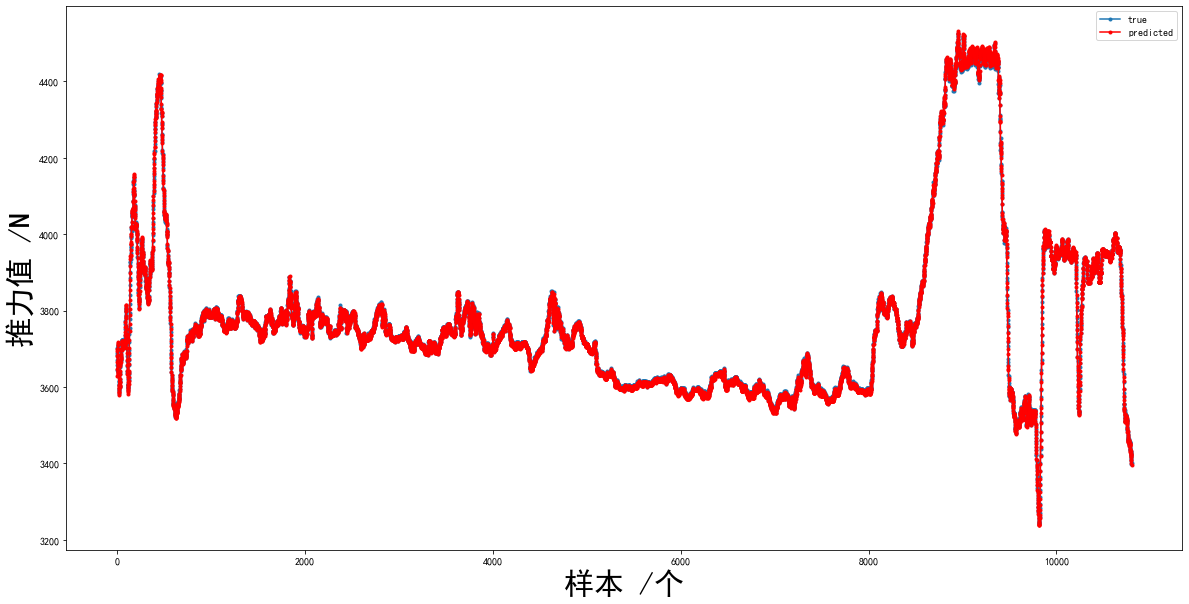

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();